<a href="https://colab.research.google.com/github/kaliole/dl-text-analytics-portfolio/blob/main/katharina_lenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


# Portfolio


This notebook demonstrates the application of various deep learning techniques and text analytics on a dataset of Crypto-related tweets. The notebook covers data preprocessing, building and training transformer models, and evaluating the models' performance.


### Data Loading & importing packages

In [ ]:
# Import necessary packages
from google.colab import drive  # To mount Google Drive for data access
import pandas as pd  # For data manipulation and analysis
from sklearn.model_selection import train_test_split  # To split the dataset into training and test sets
import tensorflow as tf  # For building and training deep learning models
import re  # For regular expressions used in text preprocessing
import string  # For string operations
from tensorflow.keras.layers import TextVectorization  # For vectorizing text data
from tensorflow.keras.metrics import Precision, Recall, AUC  # For evaluating model performance
import  numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For creating visualizations


In [ ]:
# Mount Google Drive to access datasets stored in the drive
drive.mount('/content/drive')
#!ls -al
# Define file paths for the training and testing datasets
test_file_path =  "/content/drive/MyDrive/Colab Notebooks/DELTA/Portfolio/btc_tweets_test.parquet.gzip"
train_file_path =  "/content/drive/MyDrive/Colab Notebooks/DELTA/Portfolio/btc_tweets_train.parquet.gzip"




Mounted at /content/drive


In [ ]:
def load_data(path):
  """
    Loads the dataset from the given path and preprocesses it.

    This function:
    - Reads the dataset from a parquet file.
    - Converts the 'sentiment' column to binary values (1 for True, 0 for False).
    - Selects the 'content' and 'sentiment' columns for further analysis.

    Args:
        path (str): The file path to the dataset.

    Returns:
        pd.DataFrame: A DataFrame containing the 'content' and 'sentiment' columns.
    """

  data_df = pd.read_parquet(path)
  data_df['sentiment'] = data_df['sentiment'].map({True : 1, False: 0})
  result_data = data_df.loc[:,['content', 'sentiment']]

  # Uncomment the lines below for debugging and to preview the data
  # print(result_data.head())
  # print(result_data.shape)

  return result_data

In [ ]:
train_df = load_data(train_file_path)
test_df = load_data(test_file_path)

###Data Exploration

#####Class Imbalance

In [ ]:
# Function to visualize and print class imbalance in the dataset

def class_imbalance(train_df, test_df):
  """
    Analyzes and visualizes the class imbalance in the training dataset.

    This function:
    - Counts the number of positive and negative samples in the training dataset.
    - Calculates the percentage of positive and negative samples.
    - Visualizes the class distribution as a pie chart.
    - Prints the percentage of positive and negative samples.

    Parameters:
    train_df (DataFrame): The training dataset containing a 'sentiment' column with class labels.
    test_df (DataFrame): The test dataset (not used in this function but kept for consistency).

    Returns:
    None
    """

  # Count the number of positive and negative samples in the training dataset
  positive_count = train_df['sentiment'].value_counts()[1]  # Assuming 1 is the label for positive
  negative_count = train_df['sentiment'].value_counts()[0]  # Assuming 0 is the label for negative

  # Total number of samples in the training dataset
  total_count = len(train_df)

  # Calculate percentages
  positive_percentage = (positive_count / total_count) * 100
  negative_percentage = (negative_count / total_count) * 100

  # Create an array for the counts to visualize in a pie chart
  y = np.array([positive_count,negative_count])
  mylabels = ['Positive','Negative']
  plt.pie(y,labels=mylabels,autopct='%.2f')
  plt.show()
  # Print the percentage results
  print(f"Positive: {positive_percentage:.2f}%")
  print(f"Negative: {negative_percentage:.2f}%")

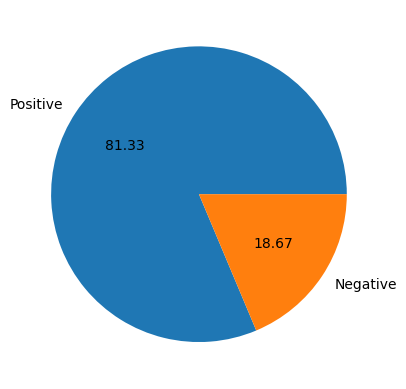

Positive: 81.33%
Negative: 18.67%


In [ ]:
class_imbalance(train_df, test_df)

We can see that there is class imbalance that will affect the accuracy of the prediction. This will likely cause the model to be biased towards preciting class 1 (positive sentiment). Further in the Notebook we will address this Class Imbalance, to avoid this bias.

### Data Preprocessing


In [ ]:
# Import necessary packages
!pip install emot -qq
import re
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
def split_data(data):

  """
    Splits the dataset into training and validation sets.

    This function:
    - Splits the 'content' and 'sentiment' columns into training and validation datasets.
    - Uses an 80-20 split for training and validation.
    - Ensures reproducibility with a fixed random state.

    Parameters:
    data (pd.DataFrame): The input dataset containing 'content' and 'sentiment' columns.

    Returns:
    tuple: Four elements are returned:
        - X_train (pd.Series): Training data for 'content'.
        - X_val (pd.Series): Validation data for 'content'.
        - y_train (pd.Series): Training labels for 'sentiment'.
        - y_val (pd.Series): Validation labels for 'sentiment'.
    """

  X_train, X_val, y_train, y_val = train_test_split(data['content'], data['sentiment'], test_size = 0.2, random_state = 5)

  return X_train, X_val, y_train, y_val


The preprocess_text function removes all text parts that are not necessary for the analysis, as they do not provide any information about the sentiment of the tweet. This includes HTML tags, Twitter handles and URLs, as they either represent metadata of the X (former Twitter) data or do not allow any conclusions to be drawn about the sentiment of the tweet. Hashtags are also removed as they are mainly used to indicate the topic of the tweet (#bitcoin or #crypto) and not the sentiment. Emojis, on the other hand, are used to represent emotions and can be a valuable tool for analysing sentiment. All emojis known to the emot library are converted to their textual representation (using the convertig_emojis function) so that their sentiment can be learnt from the models. Other emojis that are not known to the library and are represented in Unicode are deleted, as are all other unnecessary Unicode selectors.



In [ ]:
def converting_emojis(text):
  """
    Converts emojis in the input text to their textual representation.

    This function:
    - Iterates over each emoji in the text.
    - Replaces the emoji with its corresponding textual description, with underscores replacing spaces.
    - Adds spaces around the text replacement to ensure it doesn't merge with surrounding words.

    Parameters:
    text (str): The input text containing emojis.

    Returns:
    str: The text with emojis converted to their textual representation.
    """

  for emot in UNICODE_EMOJI:
    if emot in text:
            # Convert the emoji to its textual description with underscores
            emoji_text = " " + "_".join(UNICODE_EMOJI[emot].replace(",", "").replace(":", "").split()) + " "
            text = text.replace(emot, emoji_text)
  return text



def preprocess_text(text):
    """
    Preprocesses the input text by performing the following operations:
    - Removes Unicode variation selectors that are unnecessary.
    - Converts emojis to their textual representations using the converting_emojis function.
    - Converts all characters to lowercase.
    - Removes HTML tags, hashtags, Twitter handles, URLs, backslashes, and punctuation.
    - Reduces multiple spaces to a single space.

    Parameters:
    text (str): The input text string to preprocess.

    Returns:
    str: The cleaned and preprocessed text.
    """

    text = re.sub(u'\uFE0F', '', text)
    text = converting_emojis(text)
    text = text.lower()  # Convert to lowercase
    text = re.sub('<br />', ' ', text)  # Remove HTML
    text = re.sub(r'#\S+', ' ', text)  # Remove hashtags
    text = re.sub(r'@\S+', ' ', text)  # Remove Twitter handles
    text = re.sub(r'https?[^\s/$.?#].[^\s]*', ' ', text)  # Remove URLs
    text = re.sub(r'\\\S*', ' ', text)  # Replace backslashes and following characters
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove double spaces
    return text


def custom_standardization(input_text):
    """
    Applies a custom standardization to the input text.

    This function:
    - Converts all characters in the input text to lowercase.
    - Assumes that more complex text preprocessing steps have already been handled, making this step simple.

    Parameters:
    input_text (tf.Tensor): A TensorFlow string tensor representing the input text.

    Returns:
    tf.Tensor: A TensorFlow string tensor with all characters converted to lowercase.
    """

    return tf.strings.lower(input_text)




In [ ]:
# Vectorized Layer Setup


# Define the size of the vocabulary and the maximum number of words in a sequence
vocab_size = 10000 # Limit the vocabulary to the 10,000 most frequent words
seq_length = 100 # Limit the sequence length to 100 words


# Create a vectorization layer
# The TextVectorization layer will convert text to sequences of integers, where each integer represents a word in the vocabulary
vectorize_layer = TextVectorization(
    standardize=custom_standardization,  # Apply custom standardization (e.g., lowercase conversion)
    max_tokens=vocab_size,  # Limit the vocabulary to the top 10,000 words
    output_sequence_length=seq_length  # Limit the sequence length to 100 words
)




In [ ]:
# Apply Data preprocessing

#Split the data into training, validationa and test sets
X_train, X_val, y_train, y_val = split_data(train_df)# Split the training data into training and validation sets
X_test = test_df['content'] # Extract the content column for the test set
y_test = test_df['sentiment'] # Extract the sentiment labels for the test set

#for row in X_train:
#  print(preprocess_text(row))

# Apply preprocessing to each dataset
X_train_prep = X_train.apply(preprocess_text)
X_val_prep = X_val.apply(preprocess_text)
X_test_prep = X_test.apply(preprocess_text)


# Adapt the vectorization layer to the training data
vectorize_layer.adapt(X_train_prep)

# Retrieve computed vocabulary and store it
vocab = vectorize_layer.get_vocabulary()

# Transform sequences of words to sequences of integers and convert labels to tensors
X_train_vec = vectorize_layer(X_train)
y_train = tf.convert_to_tensor(y_train)

X_val_vec = vectorize_layer(X_val)
y_val = tf.convert_to_tensor(y_val)

X_test_vec = vectorize_layer(X_test)
y_test = tf.convert_to_tensor(y_test)

###VADER




When it comes to analyzing sentiment in Bitcoin-related tweets, VADER is a good choice because it’s specifically designed to handle informal, short, and emotive language that’s common on social media. Unlike other tools like PySentiment or TextBlob, VADER is better at picking up on the nuances of tweets, such as sarcasm, slang, and even the intensity of sentiment (how strongly positive or negative a tweet is). Overall, VADER’s design makes it more effective for social media data, helping us get more accurate and meaningful insights from the sentiment analysis of tweets.



In [ ]:
# Install and Import the VADER Sentiment Analysis Library
!pip install vaderSentiment -qq
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
# Function to perform VADER sentiment analysis and convert results to binary labels

def vader_sentiment_analysis(text_data, threshold=0.05):
    """
    Performs VADER sentiment analysis on a list of text data and converts the results into binary labels.

    This function:
    - Analyzes the sentiment of each text using VADER's polarity_scores method.
    - Converts the compound sentiment score to binary labels based on a specified threshold.
    - Stores the analysis results and binary labels in a DataFrame.

    Parameters:
    text_data (list or pd.Series): The text data to analyze.
    threshold (float): The threshold above which a compound score is considered positive sentiment (default is 0.05).

    Returns:
    pd.DataFrame: A DataFrame containing the VADER analysis results and binary labels.
    """

    analyzer = SentimentIntensityAnalyzer()  # Initialize the VADER sentiment analyzer
    vader_outputs = []  # Initialize a list to store the sentiment analysis outputs

    for content in text_data:  # Iterate over each piece of content
        vader_outputs.append(analyzer.polarity_scores(content))  # Analyze the sentiment and append the result

    # Convert the list of VADER outputs to a DataFrame
    vader_df = pd.DataFrame(vader_outputs)

    # Convert the compound score to binary labels based on the threshold
    vader_df['binary_label'] = vader_df['compound'].apply(lambda x: 1 if x > threshold else 0)

    return vader_df



In [ ]:
# Perform VADER sentiment analysis on the test set
vader_results = vader_sentiment_analysis(X_test)

# Extract the binary predictions
pred_vader = vader_results['binary_label']

# Print the binary predictions for review
print(pred_vader)

0      1
1      0
2      1
3      0
4      0
      ..
495    1
496    1
497    1
498    1
499    1
Name: binary_label, Length: 500, dtype: int64


###RNN-base language classifier in keras


In [ ]:
# Import necessary libraries for building, training, and optimizing the RNN model

import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
! pip install optuna -qq
import optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


#####Adressing Class imbalance:

In [ ]:
def compute_class_weights(y_train):
    """
    Computes class weights to address class imbalance in the training labels.

    This function:
    - Computes the class weights using the `compute_class_weight` function from scikit-learn.
    - Maps the computed weights to their corresponding classes (0 and 1).

    Parameters:
    y_train (tf.Tensor): A tensor containing the training labels (0 and 1).

    Returns:
    dict: A dictionary with class weights mapped to classes {0: weight_for_class_0, 1: weight_for_class_1}.
    """

    # Compute class weights based on the frequency of each class
    class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train.numpy())

    # Map the class weights to their respective classes
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    return class_weight_dict


In [ ]:
# Compute class weights for the training labels
class_weight = compute_class_weights(y_train)

# Print the computed class weights for review
print(class_weight)


{0: 2.6666666666666665, 1: 0.6153846153846154}


Class 0 (1) is underrepresented (overrepresented) compared to class 1 (0). To address this imbalance, the model will give (less) more importance to instances of class 0 (1) during training. The weight of 2.665 (0.615) indicates that each instance of class 0 will be treated as if it's 2.665 (0.615) times as important than an instance of class 1 (0).

##### Additional RNN Components





I chose to use some Regularization techniques to  prevent overfitting, which is crucial when dealing with textual data that may vary significantly in style or content, like tweets.
*   Dropout:
    Prevents overfitting by randomly omitting neurons during training, which forces the model to learn redundant representations and be less reliant on any single feature or path.
*   L2 Regularization:
    Helps to prevent the model from learning excessively large weights, which can lead to overfitting. It adds a penalty on the magnitude of parameters.
  
Additionally I implemented Callbacks to facilitate monitoring my model's training, making adjustments and preventing overfitting.


*   Early Stopping: Monitores the validation loss during training and stops the training process if the metric doesn't improve. This stops the training once the model hast stopped imrpving on the validation set.
*   ReduceLROnPlateau: Reduces the learning rate when the validation loss has stopped improving. This allows the model to converge more slowly and potentially escape local minima as training progresses.


In [ ]:
# Function to build and compile a GRU-based model for Bayesian optimization


def create_model(trial):
    """
    Builds and compiles a TensorFlow model using the hyperparameters suggested by Optuna for each trial.

    This function:
    - Defines the model architecture using a Bidirectional GRU layer, embedding layer, and dropout.
    - Uses hyperparameters for embedding size, GRU units, dropout rate, and L2 regularization, all suggested by Optuna.
    - Compiles the model with binary crossentropy loss and several evaluation metrics.

    Parameters:
    trial (optuna.Trial): A trial object from Optuna that suggests hyperparameters for the model.

    Returns:
    tf.keras.Model: A compiled TensorFlow model ready for training.
    """

    # Hyperparameter suggestions from Optuna
    emb_size = trial.suggest_categorical('emb_size', [32, 64, 128])
    rnn_units = trial.suggest_categorical('rnn_units', [16, 32, 64])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.7)
    l2_rate = trial.suggest_loguniform('l2_rate', 1e-4, 1e-1)

    # Model architecture
    input = tf.keras.Input(shape=(seq_length,), dtype="int64")  # Input layer with sequence length
    emb = Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(input)  # Embedding layer
    x = Bidirectional(GRU(rnn_units, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))(emb)  # Bidirectional GRU layer with L2 regularization
    x = Dropout(dropout_rate)(x)  # Dropout layer to prevent overfitting
    output = Dense(1, activation="sigmoid")(x)  # Output layer with sigmoid activation for binary classification

    model = tf.keras.Model(inputs=input, outputs=output)  # Define the model

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=[
              'accuracy',
              Precision(name='precision'),
              Recall(name='recall'),
              AUC(name='auc')
            ]
    )
    return model





### Tuning Hyperparameters using Bayesian optimization


When it comes to tuning the hyperparameters of our model, Bayesian Optimization is a smart choice because it’s more efficient and effective than traditional methods like grid search or even cross-validation. Instead of just blindly trying out combinations of hyperparameters, Bayesian Optimization uses what it’s learned from previous trials to make informed guesses about what hyperparameters might work best next. This means it can find the optimal settings faster and with fewer trials, which is especially handy when training models can be time-consuming or computationally expensive. While cross-validation is great for evaluating model performance, Bayesian Optimization is more strategic in finding the best hyperparameters, saving us time and computational resources, while offering a good balance between efficiency and effectiveness when working with large datasets.

In [ ]:

# Objective function for Optuna to optimize the model's hyperparameters

def objective(trial):
    """
    Objective function for Optuna that builds, trains, and evaluates a GRU-based model
    with hyperparameters suggested by the current Optuna trial.

    This function:
    - Calls `create_model(trial)` to build a model with hyperparameters from the trial.
    - Trains the model using the training data and validates it on the validation data.
    - Uses early stopping, learning rate reduction, and model checkpoint callbacks to improve training.
    - Returns the validation loss, which Optuna aims to minimize.

    Parameters:
    trial (optuna.Trial): A trial object from Optuna that suggests hyperparameters for the model.

    Returns:
    float: The validation loss of the model, which is the objective metric for Optuna.
    """

    # Create model with the current trial's hyperparameters
    model = create_model(trial)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)
    checkpoint_filepath = f'model_trial_{trial.number}.keras'
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

    # Train the model
    history = model.fit(
        X_train_vec, y_train,
        validation_data=(X_val_vec, y_val),
        epochs=2,  # Number of epochs to train; can be adjusted based on trial results
        batch_size=128,  # Batch size for training
        callbacks=[early_stopping, reduce_lr, checkpoint],
        class_weight=class_weight  # Address class imbalance with class weights
    )

    # Evaluate the model on the validation set
    results = model.evaluate(X_val_vec, y_val)
    val_loss, val_accuracy, val_precision, val_recall, val_auc = results

    # Print evaluation metrics
    print(f'Validation Loss: {val_loss}')
    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Validation Precision: {val_precision}')
    print(f'Validation Recall: {val_recall}')
    print(f'Validation AUC: {val_auc}')

    # Optional: Plot training history for this trial
    # plot_training_history(history)  # Uncomment to plot during the study

    return val_loss  # Optuna will try to minimize this value



In [ ]:
# Run Optuna study to find the best hyperparameters

# Create and optimize the Optuna study
study = optuna.create_study(direction='minimize')  # Optuna will minimize the objective function (validation loss)
study.optimize(objective, n_trials=10)  # Optimize over 10 trials; can be increased for better results

# Display the results of the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value (Validation Loss): {trial.value}")
print("  Hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-09-13 06:39:37,053] A new study created in memory with name: no-name-6d0f4a4c-d77f-4214-9478-cdef6d9afac1


Epoch 1/2


<ipython-input-17-54d2c47b3fab>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.7)
<ipython-input-17-54d2c47b3fab>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_rate = trial.suggest_loguniform('l2_rate', 1e-4, 1e-1)


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4276 - auc: 0.5006 - loss: 1.0387 - precision: 0.7948 - recall: 0.3932
Epoch 1: val_auc improved from -inf to 0.63907, saving model to model_trial_0.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.4193 - auc: 0.5027 - loss: 1.0346 - precision: 0.7962 - recall: 0.3793 - val_accuracy: 0.8000 - val_auc: 0.6391 - val_loss: 0.9699 - val_precision: 0.8136 - val_recall: 0.9796 - learning_rate: 0.0010
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7844 - auc: 0.6202 - loss: 0.9665 - precision: 0.8358 - recall: 0.9158
Epoch 2: val_auc improved from 0.63907 to 0.66156, saving model to model_trial_0.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7825 - auc: 0.6202 - loss: 0.9663 - precision: 0.8359 - recall: 0.9126 - val_accuracy: 0.8100 - val_auc: 0.6616 - val_loss: 0.9134 - val_precision: 0.8154 - val_recall: 0.9918 - learning_rate: 0.0010
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8114 - a

[I 2024-09-13 06:39:44,107] Trial 0 finished with value: 0.913389265537262 and parameters: {'emb_size': 64, 'rnn_units': 32, 'dropout_rate': 0.4850300100921041, 'l2_rate': 0.0023156084032676908}. Best is trial 0 with value: 0.913389265537262.


Validation Loss: 0.913389265537262
Validation Accuracy: 0.8100000023841858
Validation Precision: 0.8154362440109253
Validation Recall: 0.9918367266654968
Validation AUC: 0.6615583896636963
Epoch 1/2
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3112 - auc: 0.5054 - loss: 0.7155 - precision: 0.7665 - recall: 0.2069
Epoch 1: val_auc improved from -inf to 0.64646, saving model to model_trial_1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.3105 - auc: 0.5133 - loss: 0.7116 - precision: 0.7850 - recall: 0.2008 - val_accuracy: 0.7400 - val_auc: 0.6465 - val_loss: 0.6988 - val_precision: 0.8584 - val_recall: 0.8163 - learning_rate: 0.0010
Epoch 2/2
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5343 - auc: 0.5716 - loss: 0.7264 - precision: 0.8199 - recall: 0.5330
Epoch 2: val_auc improved from 0.64646 to 0.67406, saving model to model_trial_1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5716 - auc: 0.5908 - loss: 0.7126 - precision: 0.8336 - recall

[I 2024-09-13 06:39:47,393] Trial 1 finished with value: 0.6894155144691467 and parameters: {'emb_size': 32, 'rnn_units': 32, 'dropout_rate': 0.5445647836665339, 'l2_rate': 0.00011050188903174033}. Best is trial 1 with value: 0.6894155144691467.


Validation Loss: 0.6894155144691467
Validation Accuracy: 0.7866666913032532
Validation Precision: 0.8494208455085754
Validation Recall: 0.8979591727256775
Validation AUC: 0.6740630865097046
Epoch 1/2
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3989 - auc: 0.5101 - loss: 12.5766 - precision: 0.8151 - recall: 0.3292
Epoch 1: val_auc improved from -inf to 0.62464, saving model to model_trial_2.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.4105 - auc: 0.5150 - loss: 12.3920 - precision: 0.8173 - recall: 0.3471 - val_accuracy: 0.8033 - val_auc: 0.6246 - val_loss: 9.5836 - val_precision: 0.8298 - val_recall: 0.9551 - learning_rate: 0.0010
Epoch 2/2
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7802 - auc: 0.6421 - loss: 9.1152 - precision: 0.8563 - recall: 0.8808
Epoch 2: val_auc improved from 0.62464 to 0.64594, saving model to model_trial_2.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7715 - auc: 0.6377 - loss: 9.0306 - precision: 0.8547 - rec

[I 2024-09-13 06:39:50,950] Trial 2 finished with value: 7.477075099945068 and parameters: {'emb_size': 128, 'rnn_units': 64, 'dropout_rate': 0.5388148727093374, 'l2_rate': 0.04285281863850401}. Best is trial 1 with value: 0.6894155144691467.


Validation Loss: 7.477075099945068
Validation Accuracy: 0.8166666626930237
Validation Precision: 0.8345070481300354
Validation Recall: 0.9673469662666321
Validation AUC: 0.645936906337738
Epoch 1/2
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5485 - auc: 0.4793 - loss: 12.7854 - precision: 0.8134 - recall: 0.5853
Epoch 1: val_auc improved from -inf to 0.63599, saving model to model_trial_3.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5613 - auc: 0.4819 - loss: 12.6462 - precision: 0.8121 - recall: 0.6060 - val_accuracy: 0.8067 - val_auc: 0.6360 - val_loss: 10.4699 - val_precision: 0.8148 - val_recall: 0.9878 - learning_rate: 0.0010
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7421 - auc: 0.6617 - loss: 10.0748 - precision: 0.8344 - recall: 0.8490
Epoch 2: val_auc improved from 0.63599 to 0.67373, saving model to model_trial_3.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7419 - auc: 0.6603 - loss: 10.0421 - precision: 0.8345 - re

[I 2024-09-13 06:39:54,976] Trial 3 finished with value: 8.733281135559082 and parameters: {'emb_size': 128, 'rnn_units': 16, 'dropout_rate': 0.5466326305608545, 'l2_rate': 0.09248676193428441}. Best is trial 1 with value: 0.6894155144691467.


Validation Loss: 8.733281135559082
Validation Accuracy: 0.8166666626930237
Validation Precision: 0.8209459185600281
Validation Recall: 0.9918367266654968
Validation AUC: 0.6737291812896729
Epoch 1/2
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6285 - auc: 0.4716 - loss: 8.9950 - precision: 0.8056 - recall: 0.7165
Epoch 1: val_auc improved from -inf to 0.60612, saving model to model_trial_4.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6492 - auc: 0.4816 - loss: 8.9015 - precision: 0.8070 - recall: 0.7475 - val_accuracy: 0.8067 - val_auc: 0.6061 - val_loss: 7.3992 - val_precision: 0.8148 - val_recall: 0.9878 - learning_rate: 0.0010
Epoch 2/2
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8174 - auc: 0.6351 - loss: 7.1519 - precision: 0.8337 - recall: 0.9716
Epoch 2: val_auc improved from 0.60612 to 0.61603, saving model to model_trial_4.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8156 - auc: 0.6375 - loss: 7.1055 - precision: 0.8327 - recall

[I 2024-09-13 06:39:58,353] Trial 4 finished with value: 6.214158535003662 and parameters: {'emb_size': 128, 'rnn_units': 16, 'dropout_rate': 0.32352712104384596, 'l2_rate': 0.0633831621340433}. Best is trial 1 with value: 0.6894155144691467.


Validation Loss: 6.214158535003662
Validation Accuracy: 0.8133333325386047
Validation Precision: 0.8292682766914368
Validation Recall: 0.9714285731315613
Validation AUC: 0.6160297393798828
Epoch 1/2
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7188 - auc: 0.5456 - loss: 8.6102 - precision: 0.8211 - recall: 0.8418
Epoch 1: val_auc improved from -inf to 0.59811, saving model to model_trial_5.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.7284 - auc: 0.5471 - loss: 8.3859 - precision: 0.8193 - recall: 0.8571 - val_accuracy: 0.8100 - val_auc: 0.5981 - val_loss: 7.1819 - val_precision: 0.8154 - val_recall: 0.9918 - learning_rate: 0.0010
Epoch 2/2
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7453 - auc: 0.5785 - loss: 7.0752 - precision: 0.8164 - recall: 0.8825
Epoch 2: val_auc improved from 0.59811 to 0.62353, saving model to model_trial_5.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7560 - auc: 0.5896 - loss: 6.9509 - precision: 0.8221 - recall

[I 2024-09-13 06:40:01,562] Trial 5 finished with value: 6.210024356842041 and parameters: {'emb_size': 32, 'rnn_units': 32, 'dropout_rate': 0.5999813518012356, 'l2_rate': 0.08466387851239252}. Best is trial 1 with value: 0.6894155144691467.


Validation Loss: 6.210024356842041
Validation Accuracy: 0.7866666913032532
Validation Precision: 0.8415094614028931
Validation Recall: 0.9102040529251099
Validation AUC: 0.6235250234603882
Epoch 1/2
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6280 - auc: 0.4958 - loss: 0.8861 - precision: 0.8221 - recall: 0.7012
Epoch 1: val_auc improved from -inf to 0.64412, saving model to model_trial_6.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6432 - auc: 0.4992 - loss: 0.8859 - precision: 0.8200 - recall: 0.7268 - val_accuracy: 0.8033 - val_auc: 0.6441 - val_loss: 0.8561 - val_precision: 0.8345 - val_recall: 0.9469 - learning_rate: 0.0010
Epoch 2/2
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6794 - auc: 0.5832 - loss: 0.8748 - precision: 0.8262 - recall: 0.7650
Epoch 2: val_auc improved from 0.64412 to 0.67785, saving model to model_trial_6.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6962 - auc: 0.5965 - loss: 0.8680 - precision: 0.8282 - recall

[I 2024-09-13 06:40:04,915] Trial 6 finished with value: 0.8304070830345154 and parameters: {'emb_size': 128, 'rnn_units': 32, 'dropout_rate': 0.5346677201021655, 'l2_rate': 0.0009088308874492779}. Best is trial 1 with value: 0.6894155144691467.


Validation Loss: 0.8304070830345154
Validation Accuracy: 0.800000011920929
Validation Precision: 0.8388278484344482
Validation Recall: 0.9346938729286194
Validation AUC: 0.6778478622436523
Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4829 - auc: 0.4861 - loss: 0.8802 - precision: 0.7953 - recall: 0.4784
Epoch 1: val_auc improved from -inf to 0.62256, saving model to model_trial_7.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.4853 - auc: 0.4900 - loss: 0.8775 - precision: 0.7981 - recall: 0.4805 - val_accuracy: 0.8133 - val_auc: 0.6226 - val_loss: 0.7969 - val_precision: 0.8161 - val_recall: 0.9959 - learning_rate: 0.0010
Epoch 2/2
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8087 - auc: 0.5970 - loss: 0.8389 - precision: 0.8260 - recall: 0.9674
Epoch 2: val_auc improved from 0.62256 to 0.65058, saving model to model_trial_7.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8112 - auc: 0.6087 - loss: 0.8336 - precision: 0.8272 - recall

[I 2024-09-13 06:40:08,335] Trial 7 finished with value: 0.7877029180526733 and parameters: {'emb_size': 128, 'rnn_units': 16, 'dropout_rate': 0.5394529608162657, 'l2_rate': 0.0011943161106049004}. Best is trial 1 with value: 0.6894155144691467.


Validation Loss: 0.7877029180526733
Validation Accuracy: 0.8199999928474426
Validation Precision: 0.8350877165794373
Validation Recall: 0.9714285731315613
Validation AUC: 0.6505751609802246
Epoch 1/2
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4181 - auc: 0.4656 - loss: 0.7493 - precision: 0.7990 - recall: 0.3677
Epoch 1: val_auc improved from -inf to 0.62308, saving model to model_trial_8.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.4218 - auc: 0.4835 - loss: 0.7426 - precision: 0.8098 - recall: 0.3704 - val_accuracy: 0.8300 - val_auc: 0.6231 - val_loss: 0.7206 - val_precision: 0.8368 - val_recall: 0.9837 - learning_rate: 0.0010
Epoch 2/2
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7368 - auc: 0.5893 - loss: 0.7393 - precision: 0.8196 - recall: 0.8642
Epoch 2: val_auc improved from 0.62308 to 0.62468, saving model to model_trial_8.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7525 - auc: 0.5993 - loss: 0.7320 - precision: 0.8242 - recal

[I 2024-09-13 06:40:12,091] Trial 8 finished with value: 0.7189339995384216 and parameters: {'emb_size': 32, 'rnn_units': 16, 'dropout_rate': 0.36109461131319853, 'l2_rate': 0.0005459784675483514}. Best is trial 1 with value: 0.6894155144691467.


Validation Loss: 0.7189339995384216
Validation Accuracy: 0.8066666722297668
Validation Precision: 0.8424908518791199
Validation Recall: 0.9387755393981934
Validation AUC: 0.6246752738952637
Epoch 1/2
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7697 - auc: 0.5426 - loss: 0.7496 - precision: 0.8221 - recall: 0.9165
Epoch 1: val_auc improved from -inf to 0.65299, saving model to model_trial_9.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.7717 - auc: 0.5454 - loss: 0.7506 - precision: 0.8218 - recall: 0.9200 - val_accuracy: 0.8133 - val_auc: 0.6530 - val_loss: 0.7193 - val_precision: 0.8161 - val_recall: 0.9959 - learning_rate: 0.0010
Epoch 2/2
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8068 - auc: 0.6247 - loss: 0.7478 - precision: 0.8259 - recall: 0.9665
Epoch 2: val_auc improved from 0.65299 to 0.66750, saving model to model_trial_9.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8069 - auc: 0.6281 - loss: 0.7477 - precision: 0.8269 - recal

[I 2024-09-13 06:40:15,423] Trial 9 finished with value: 0.7193059921264648 and parameters: {'emb_size': 64, 'rnn_units': 64, 'dropout_rate': 0.4107817796415457, 'l2_rate': 0.00033715221426515246}. Best is trial 1 with value: 0.6894155144691467.


Validation Loss: 0.7193059921264648
Validation Accuracy: 0.8133333325386047
Validation Precision: 0.8160535097122192
Validation Recall: 0.9959183931350708
Validation AUC: 0.652987003326416
Best trial:
  Value (Validation Loss): 0.6894155144691467
  Hyperparameters: 
    emb_size: 32
    rnn_units: 32
    dropout_rate: 0.5445647836665339
    l2_rate: 0.00011050188903174033


In [ ]:
# Load best model
model = load_model(f'model_trial_{trial.number}.keras')

# Predict probabilities on the test data
probabilities = model.predict(X_test_vec)

# Convert probabilities to binary classes
# Here, 0.5 is used as the threshold. Adjust if necessary.
rnn_binary_pred = (probabilities > 0.5).astype(int)

# (Optional) Print rnn_binary_pred
#print(rnn_binary_pred)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


###DistilBERT


#####Applying the DIstilBERT model to the test data

In [ ]:
# Import necessary libraries for DistilBERT
from transformers import pipeline


In [ ]:
# Load the DistilBERT model for sentiment analysis using the Hugging Face pipeline
pipe = pipeline("text-classification", model="DT12the/distilbert-sentiment-analysis", device = 'cuda')

def distilbert_test(X_test):
    """
    Applies the DistilBERT model to the test data for sentiment analysis.

    This function:
    - Converts the test data to a list format.
    - Applies the DistilBERT model using the Hugging Face pipeline to classify the text.
    - Returns the classification scores for each input text.

    Parameters:
    X_test (pd.Series): A pandas Series containing the text data to be classified.

    Returns:
    list: A list of dictionaries containing the classification labels and scores for each input text.
    """
    scores = pipe(X_test.tolist())  # Convert X_test to a list if it's not already
    return scores


# Apply DistilBERT to the test data
test_results = distilbert_test(X_test)

# Convert the test results to a DataFrame
db_pred_df = pd.DataFrame(test_results)

# Map the labels to binary values for consistency with other models
db_pred_df['label'] = db_pred_df['label'].map({'LABEL_1': 1, 'LABEL_0': 0})

# Optional: Print the DataFrame to inspect the predictions
print(db_pred_df['label'])

# (Optional)): Print the predictions for each text sample (Optional)
"""
for i in range(len(test_results)):
    print(f"Text: {X_test.iloc[i]}, Prediction: {test_results[i]['label']}, Score: {test_results[i]['score']:.4f}")
"""




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

0      0
1      1
2      0
3      0
4      0
      ..
495    0
496    0
497    0
498    0
499    0
Name: label, Length: 500, dtype: int64


'\nfor i in range(len(test_results)):\n    print(f"Text: {X_test.iloc[i]}, Prediction: {test_results[i][\'label\']}, Score: {test_results[i][\'score\']:.4f}")\n'

#####Finetuning a DistilBert model




In [ ]:
# Activate GPU and Install Dependencies
# use GPU (instead of CPU) to train model faster

# Check if GPU is available for faster training
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and will be used.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")


# Install necessary libraries for working with Hugging Face's transformers and datasets
!pip install datasets transformers huggingface_hub -qq

# Import necessary modules from transformers and datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
#, load_metric
import pandas as pd
!pip install datasets transformers huggingface_hub evaluate -qq
from evaluate import load  # Changed this part

# Load a metric
load_metric = load("accuracy")  # Changed this part


GPU is available and will be used.


In [ ]:

# Load the DistilBERT tokenizer for preprocessing text data
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Prepare the data: Convert training, validation, and test data into DataFrames
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df = pd.DataFrame({'text': X_val, 'label': y_val})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

# Convert DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)



# Define a preprocessing function to tokenize the text data
def preprocess_function(examples):
    """
    Tokenizes input text data using the DistilBERT tokenizer.

    This function:
    - Truncates text sequences to a maximum length of 128 tokens.
    - Pads sequences to the maximum length if necessary.

    Parameters:
    examples (dict): A dictionary containing the text data to be tokenized.

    Returns:
    dict: A dictionary containing the tokenized inputs.
    """
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Apply the preprocessing function to the datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

# Remove the original text column as it's no longer needed
train_dataset = tokenized_train.remove_columns(["text"])
val_dataset = tokenized_val.remove_columns(["text"])
test_dataset = tokenized_test.remove_columns(["text"])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
# Load the DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)  # Move the model to the appropriate device (GPU or CPU)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:

# Define a function to compute evaluation metrics
def compute_metrics(eval_pred):
    """
    Computes accuracy and F1 score for the model's predictions.

    This function:
    - Extracts logits and labels from the evaluation predictions.
    - Converts logits to predicted labels by taking the argmax.
    - Computes accuracy and F1 score using the Hugging Face `load_metric` utility.

    Parameters:
    eval_pred (tuple): A tuple containing logits and labels from the evaluation.

    Returns:
    dict: A dictionary with computed accuracy and F1 score.
    """
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [ ]:

# Define training arguments for the Trainer API
training_args = TrainingArguments(
    output_dir='./results',  # Directory to save training results and model checkpoints
    learning_rate=2e-5,  # Initial learning rate for the Adam optimizer
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    num_train_epochs=2,  # Number of training epochs
    weight_decay=0.01,  # Weight decay to apply for regularization
    save_strategy="epoch",  # Save the model at the end of every epoch
)

# Initialize the Trainer with the model, training arguments, and datasets
trainer = Trainer(
    model=model,  # The model to be trained
    args=training_args,  # Training arguments
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=val_dataset,  # Evaluation dataset
    tokenizer=tokenizer,  # Tokenizer used for preprocessing
    compute_metrics=compute_metrics,  # Function to compute metrics during evaluation
)

In [ ]:
# Train the model

trainer.train()

Step,Training Loss


TrainOutput(global_step=150, training_loss=0.3996225992838542, metrics={'train_runtime': 30.9118, 'train_samples_per_second': 77.64, 'train_steps_per_second': 4.853, 'total_flos': 79480439193600.0, 'train_loss': 0.3996225992838542, 'epoch': 2.0})

In [ ]:
# Evaluate the model on the validation set
trainer.evaluate()

TypeError: 'Accuracy' object is not callable

In [ ]:
# Make predictions on the test dataset
raw_pred, _, _ = trainer.predict(test_dataset)

# Convert raw predictions to class labels
DistB_fine_pred = np.argmax(raw_pred, axis=1)

# Optional: Print the final predictions
#print(DistB_fine_pred)


TypeError: 'Accuracy' object is not callable

### Binary Classification Metrics


In analysis with class imbalance, accuracy alone can be misleading, as a model might achive a high accuracy by simply predicting the majority class most of the time. Adding metrics such ass confusion matric, the ROC curve or Presicion and Recal can therefore be useful. The confusion matrix helps to provide a granular view of how the model's predictions are distributed across the different classes.
AUC-ROC score helps to evaluate how well your model can distinguish between positive and negative sentiments, regardless of the specific threshold chosen for classification.

In [ ]:
# Import necessary libraries for evaluation metrics and visualizations
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluates a binary classification model using multiple metrics and visualizations.

    This function:
    - Computes accuracy, AUC-ROC, precision, recall, and F1 score.
    - Displays a confusion matrix as a heatmap.
    - Prints a detailed classification report.
    - Plots the ROC curve for the model.

    Parameters:
    y_true (np.array or list): True binary labels.
    y_pred (np.array or list): Predicted binary labels.
    model_name (str): Name of the model being evaluated (default is "Model").

    Returns:
    None
    """
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    # Print classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred))

    # Print individual metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"{model_name} Confusion Matrix:")
    plt.figure(figsize=(6, 4))
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


VADER Sentiment Analysis:
VADER Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.65      0.40        96
           1       0.88      0.62      0.72       404

    accuracy                           0.62       500
   macro avg       0.58      0.63      0.56       500
weighted avg       0.77      0.62      0.66       500

Accuracy: 0.6220
Precision: 0.8799
Recall: 0.6163
F1 Score: 0.7249
AUC-ROC: 0.6311
VADER Confusion Matrix:


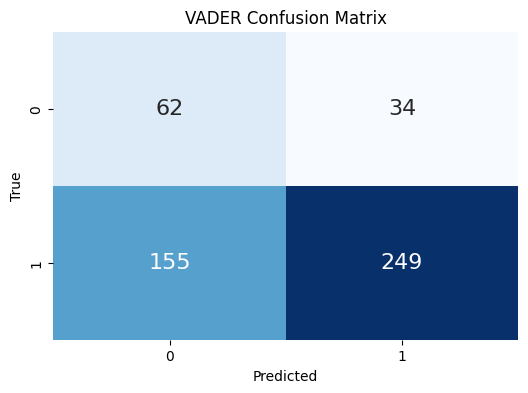

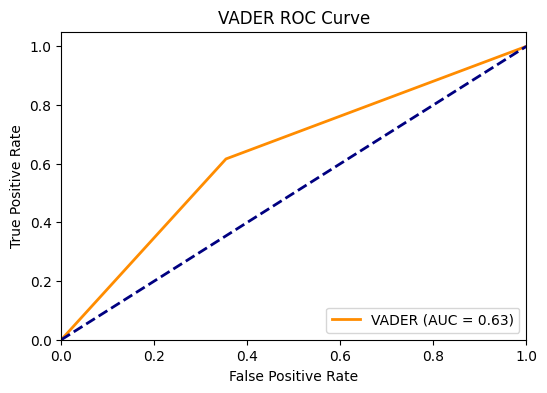


RNN Model:
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.26      0.35        96
           1       0.84      0.95      0.89       404

    accuracy                           0.82       500
   macro avg       0.70      0.61      0.62       500
weighted avg       0.79      0.82      0.79       500

Accuracy: 0.8180
Precision: 0.8440
Recall: 0.9505
F1 Score: 0.8941
AUC-ROC: 0.6055
RNN Confusion Matrix:


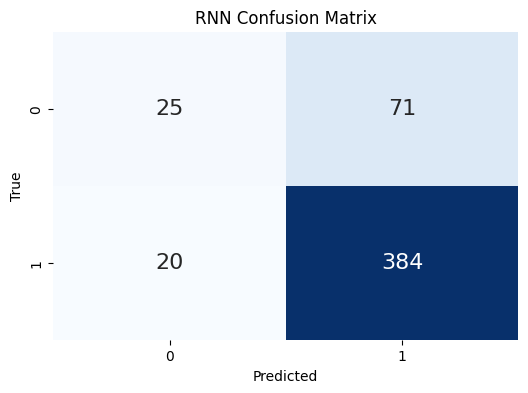

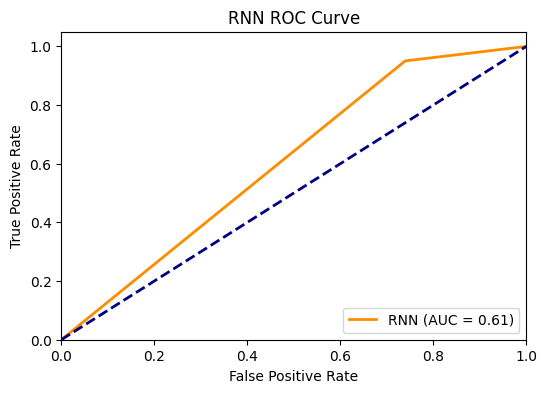


Original DistilBERT Model:
Original DistilBERT Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.47      0.17        96
           1       0.27      0.05      0.08       404

    accuracy                           0.13       500
   macro avg       0.19      0.26      0.13       500
weighted avg       0.24      0.13      0.10       500

Accuracy: 0.1280
Precision: 0.2714
Recall: 0.0470
F1 Score: 0.0802
AUC-ROC: 0.2579
Original DistilBERT Confusion Matrix:


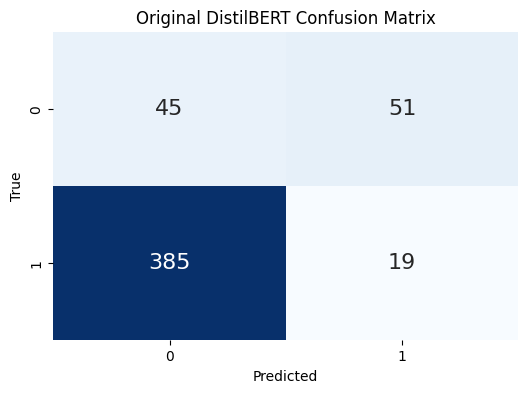

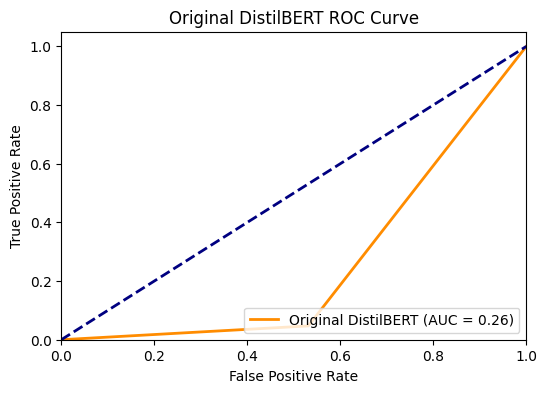


Fine-tuned DistilBERT Model:
Fine-tuned DistilBERT Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.36      0.50        96
           1       0.87      0.98      0.92       404

    accuracy                           0.86       500
   macro avg       0.82      0.67      0.71       500
weighted avg       0.85      0.86      0.84       500

Accuracy: 0.8580
Precision: 0.8659
Recall: 0.9752
F1 Score: 0.9173
AUC-ROC: 0.6699
Fine-tuned DistilBERT Confusion Matrix:


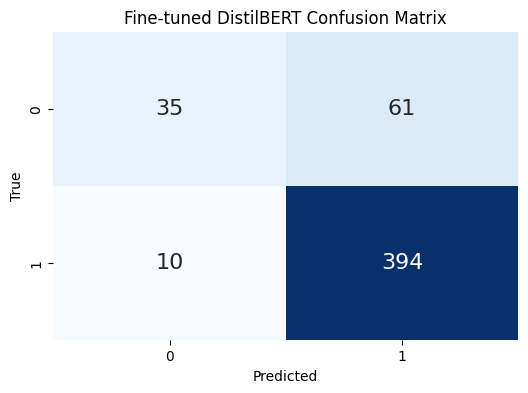

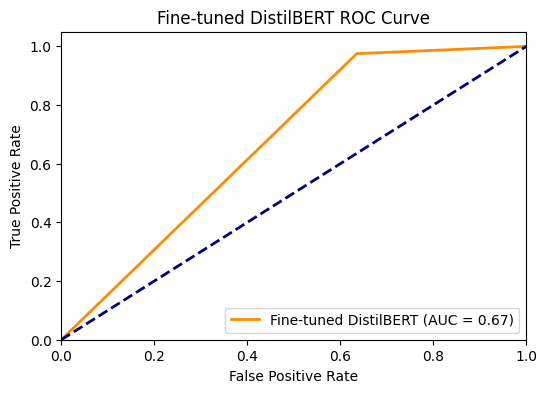

In [ ]:
# Evaluate different models
print("VADER Sentiment Analysis:")
evaluate_model(y_test, pred_vader, model_name="VADER")

print("\nRNN Model:")
evaluate_model(y_test, rnn_binary_pred, model_name="RNN")

print("\nOriginal DistilBERT Model:")
evaluate_model(y_test, db_pred_df['label'], model_name="Original DistilBERT")

print("\nFine-tuned DistilBERT Model:")
evaluate_model(y_test, DistB_fine_pred, model_name="Fine-tuned DistilBERT")

### Conclusion

For my sentiment analysis of Bitcoin-related tweets, I experimented with four different models: VADER, an RNN, the original DistilBERT transformer, and a fine-tuned version of DistilBERT. Here's how each one performed:

Starting with VADER, it did a decent job, especially in picking up positive sentiments, with a precision score of 0.88. But it struggled with negative sentiments, with a recall of just 0.29, meaning it often missed the negative tweets. Overall, VADER ended up with an accuracy of 62.2% and an AUC-ROC of 0.63. So, while it's okay at telling positive from negative, it’s not great—especially at catching the negative stuff. It’s good if you want precision in positive sentiment, but we shouldn't count on it to spot the negative tweets reliably.

The RNN model, on the other hand, performed noticeably better. It achieved an accuracy of 81.8% and a F1 score of 0.89 for positive tweets. Its recall for positive sentiments was at 0.95, meaning it was pretty good at identifying positive tweets. But like VADER, it had a tough time with negatives, with its recall dropping to 0.26. The AUC-ROC was 0.61, which suggests that while the RNN is pretty good, it's not outstanding at distinguishing between positive and negative sentiments. So, it's great at spotting positive vibes, but not so much the negative ones.

Now, the original DistilBERT model had a very low accuracy of just 12.8% and an AUC-ROC of 0.26. It struggled with poor precision and recall for both positive and negative sentiments. The F1 score was also really low, which just confirms that this model wasn’t effective at capturing the sentiment in these tweets. This performance shows that without fine-tuning, the base DistilBERT model just isn't cut out for this specific task.

The fine-tuned DistilBERT model reached an accuracy of 85.8% and a high F1 score of 0.92 for positive sentiments. It had excellent recall (0.98) for positive tweets and even improved recall for negative ones compared to the RNN. Its AUC-ROC of 0.67 was the highest among all the models, making it the best at distinguishing between positive and negative sentiments. This fine-tuned version excelled in both precision and recall, making it the top performer for this task. However, there’s still some room for improvement when it comes to catching negative sentiments.

To sum it up, the fine-tuned DistilBERT model clearly came out on top for this sentiment analysis. It provided the most reliable and accurate results overall. The RNN also did well, especially in identifying positive tweets, while VADER offered a solid, if less powerful, alternative. The original DistilBERT’s poor performance really highlights how crucial fine-tuning is for transformer models in specific tasks. In the end, the fine-tuned DistilBERT is the best choice for analyzing sentiment in Bitcoin tweets.
What stood out is, that all models struggled to identify the negative tweets which is pribably due to the class imbalance of the training data. This may give even more room for improving and tuning the models in addition to the weights which were added to the rnn.

###Downloading Zip file an requirement.txt

In [ ]:
!pip freeze > requirements.txt
from google.colab import files
files.download('requirements.txt')


!zip -r Katharina_Lenz_Notebook.zip /content/drive/MyDrive/Katharina_Lenz.ipynb requirements.txt

from google.colab import files
files.download('Katharina_Lenz_Notebook.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: content/drive/MyDrive/Katharina_Lenz.ipynb (deflated 54%)
updating: requirements.txt (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>